In [1]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import os
import numpy as np
import torch
import onnxruntime
import tqdm as tqdm
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic
import matplotlib.pyplot as plt
from dataset import StereoDataset, StereoSegmentationDataset
from transforms import transform_disparity_fn, transform_fn
from torch.utils.data import Dataset, DataLoader

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

vit_checkpoint = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

# download the checkpoint to  tmp
# !wget -O tmp/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget -O tmp/sam_vit_l_0b3195.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# !wget -O tmp/sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth



Using device: cuda


In [ ]:
sam = sam_model_registry["vit_b"](checkpoint="tmp/sam_vit_b_01ec64.pth")
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

vit_checkpoint = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

# download the checkpoint to  tmp
# !wget -O tmp/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


image_folders = [
                #  'tmp/data/train/left_images',
                 'tmp/data/train/left_images',
                 'tmp/data/test/left_images',
                 'tmp/data/train/disparity_maps',
                 'tmp/data/test/disparity_maps',
                 'tmp/data/train/depth_maps'
                #  'tmp/data/test/right_images'
                ]

In [ ]:
# analyze the images in the folders
image_sizes = {
}



for image_folder in image_folders:
    image_sizes[image_folder] = {}
    for root, dirs, files in os.walk(image_folder):
        # store RGB statistics for the images for normalization during training
        image_stats = {
            "mean": [0, 0, 0],
            "std": [0, 0, 0]
        }
        files_processed = 0
        for file in tqdm.tqdm(files):
            if file.endswith(".jpg") or file.endswith(".png"):
                files_processed += 1
                image = cv2.imread(os.path.join(root, file))
                # get image size
                h, w = image.shape[:2]
                if (h, w) not in image_sizes[image_folder]:
                    image_sizes[image_folder][(h, w)] = 0

                image_sizes[image_folder][(h, w)] += 1

                # get image stats
                image = image / 255.0
                image_stats["mean"] += image.mean(axis=(0, 1))
                image_stats["std"] += image.std(axis=(0, 1))
        
        image_stats["mean"] /= files_processed
        image_stats["std"] /= files_processed
        print(f"{image_folder}:\n{image_stats}")        

print(image_sizes)



In [ ]:
base_image = "2018-10-11-16-03-19_2018-10-11-16-58-57-454"

image = cv2.imread(f"sample/left_images/{base_image}.jpg")
depth_map = cv2.imread(f"sample/disparity_maps/{base_image}.png", cv2.IMREAD_GRAYSCALE)

print(f"shape of original image: {image.shape}")
# equalize the histogram of the depth map
depth_map = cv2.equalizeHist(depth_map)


# show the image and the depth map side by side using matplotlib

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image")
plt.axis("off")
plt.subplot(1, 2, 2)

# depth map is a single channel image, so we can directly plot it
plt.imshow(depth_map, cmap="gray")
plt.title("Depth Map")
plt.axis("off")
plt.show()

# select 8 random points along the top of left image and make sure the pixel values are zero on the 
# depth map

# get the height and width of the image
height, width = image.shape[:2]

# select 16 random points along the top of the image
x_coors = np.random.randint(0, width, (16))
points = [(x, 0) for x in x_coors]

# make sure the depth map values are zero at these points
valid_points = []
for x, y in points:
    if depth_map[y, x] == 0:
        valid_points.append((x, y))

# draw those points on the left image


image_with_points = image.copy()
for x, y in valid_points:
    cv2.circle(image_with_points, (x, y), 5, (0, 255, 0), -1)

# show the image with the points
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(image_with_points, cv2.COLOR_BGR2RGB))
plt.title("Image with Points")
plt.axis("off")
plt.show()

predictor = SamPredictor(sam)
print(f"shape of input image to the model: {image.shape}")
predictor.set_image(image)
point_labels = [0] * len(points)
point_labels = np.array(point_labels)
points = np.array(points)
masks, _, _ = predictor.predict(points, point_labels=point_labels)

valid_pixels = (depth_map > 0).astype(np.uint8)

print(f"Valid pixels: {valid_pixels.sum()}")
print(f"shape of masks: {masks[0].shape}")
smallet_invalid_pixels = 0
converted_mask = np.zeros_like(valid_pixels)
for index, mask in enumerate(masks):
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] > 0 and depth_map[y, x] == 0:
                converted_mask[y, x] = 1

    # print(f"Valid pixels after mask: {converted_mask.sum()}")

    # if converted_mask.sum() > smallet_invalid_pixels:
    #     smallet_invalid_pixels = converted_mask.sum()
    #     best_mask = converted_mask
    #     best_index = index

# print(f"Best mask index: {best_index}")
# print(f"Smallest invalid pixels: {smallet_invalid_pixels}")

# process the best mask to remove the outlier patches outside the main mask

# find the contours of the mask
contours, _ = cv2.findContours(converted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

print(largest_contour)

# draw the largest contour on the mask
mask = np.zeros_like(converted_mask)
countours = cv2.drawContours(mask, [largest_contour], -1, 255, -1)

# show the mask
plt.figure(figsize=(5, 5))
plt.imshow(countours, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()

# draw the mask over the left image with some transparency

# create a copy of the image
image_with_mask = image.copy()

# add the mask to the image

# create a mask with 3 channels
mask_3_channels = np.zeros_like(image)
mask_3_channels[:, :, 0] = countours
mask_3_channels[:, :, 1] = countours
# mask_3_channels[:, :, 2] = countours

# add the mask to the image
image_with_mask = cv2.addWeighted(image_with_mask, 0.5, mask_3_channels, 0.5, 0)

# show the image with the mask
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2RGB))
plt.title("Image with Mask")
plt.axis("off")
plt.show()

In [27]:
data_set_folder = 'tmp/data'
# load transforms
transform = transform_fn()
transform_disparity = transform_disparity_fn()
BATCH_SIZE = 10
NUM_WORKERS = 1
dataset = StereoDataset(f'{data_set_folder}/train/left_images',
                        f'{data_set_folder}/train/right_images',
                        f'{data_set_folder}/train/disparity_maps',
                        f'{data_set_folder}/train/depth_maps',
                        f'calib/train/half-image-calib',
                        sky_mask_folder=f'{data_set_folder}/train/left_sky_masks',
                        transform=transform,
                        transform_disparity=transform_disparity,
                        randomFlip=True
                        )
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

Found 174437 left images
Found 174437 right images
Found 174437 disparity maps
Found 174437 depth maps
Found 174437 sky masks


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


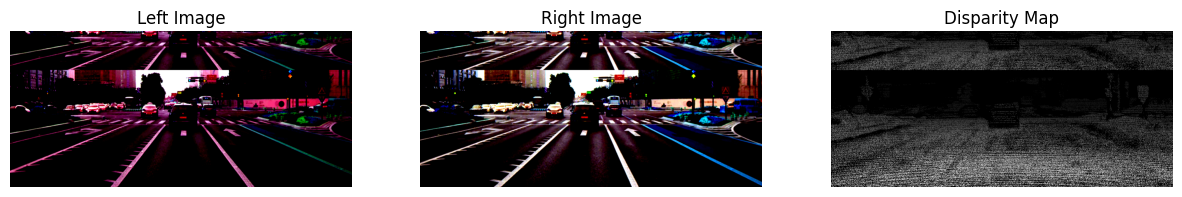

In [39]:
# sample images and show them in matplotlib

# get a batch of images
for batch in dataloader:
    left_images, right_images, disparity_maps, depth_maps, _, _, sky_masks = batch
    
    # get the first image
    left_image = left_images[0]
    right_image = right_images[0]
    disparity_map = disparity_maps[0]
    sky_masks = sky_masks[0]
    # print(left_image.max())
    # print(left_image.min())

    # show the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(left_image.permute(1, 2, 0))
    plt.title("Left Image")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(right_image.permute(1, 2, 0))
    plt.title("Right Image")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(disparity_map.squeeze(), cmap="gray")
    plt.title("Disparity Map")
    plt.axis("off")
    
    plt.show()
    break